In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
from tensorflow.keras.models import load_model
from fairmlhealth import report, measure, stat_utils
from sklearn.tree import DecisionTreeClassifier
import xgboost 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
import math
from sklearn.metrics import recall_score


In [2]:
# reads the data set from the file
train_data = pd.read_csv("cleaned_data.csv")
test_data = pd.read_csv("/Users/poojanadagouda/Documents/CSS581/project/data/test_timeseries/test_timeseries.csv")
validation_data = pd.read_csv("/Users/poojanadagouda/Documents/CSS581/project/data/validation_timeseries/validation_timeseries.csv")

In [3]:
#size of train, test, validation datsets
print(train_data.shape)
print(test_data.shape)
print(validation_data.shape)

(2756796, 22)
(2271948, 21)
(2268840, 21)


In [4]:
train_data

,Unnamed: 0,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
1,10,1001,2000-01-11,1.33,100.40,6.63,11.48,7.84,7.84,18.88,...,10.43,1.76,2.48,1.05,1.43,3.55,6.38,1.71,4.67,2.0
2,17,1001,2000-01-18,1.11,100.39,9.53,14.28,13.26,13.26,18.04,...,14.19,2.63,3.60,1.67,1.92,5.19,6.40,3.84,2.55,2.0
3,24,1001,2000-01-25,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,...,-0.61,3.35,4.59,2.28,2.32,5.75,8.03,3.96,4.07,2.0
4,31,1001,2000-02-01,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,...,1.88,2.03,2.74,0.88,1.86,4.18,6.38,1.27,5.11,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756791,1300648,56043,2016-11-29,0.04,82.47,2.19,-4.27,-9.36,-9.26,-1.51,...,-4.38,6.93,10.27,3.08,7.18,9.42,12.59,5.62,6.97,0.0
2756792,1300655,56043,2016-12-06,0.13,82.59,0.91,-11.96,-18.65,-17.90,-6.85,...,-11.98,2.27,3.97,0.95,3.02,3.07,5.16,0.83,4.33,0.0
2756793,1300662,56043,2016-12-13,0.02,82.86,1.40,-9.56,-14.18,-13.95,-2.69,...,-10.95,3.64,6.59,1.28,5.31,5.33,8.35,2.13,6.22,0.0
2756794,1300669,56043,2016-12-20,0.32,83.12,2.73,-2.55,-6.90,-6.84,2.66,...,-3.94,6.16,8.43,3.44,4.99,8.99,10.14,6.67,3.47,0.0


In [5]:
#remove nan values from test and validation datasets as well
test_data = test_data.dropna()
validation_data = validation_data.dropna()

In [6]:
#size of train, test, validation datsets after removing nan values 
print(train_data.shape)
print(test_data.shape)
print(validation_data.shape)

(2756796, 22)
(326340, 21)
(323232, 21)


In [7]:
#rounding drought scores to integers
validation_data['score'] = validation_data.score.round()
test_data['score'] = test_data.score.round()

In [10]:
# drought score distribution in train, test and validation datasets
print("test: \n",test_data['score'].value_counts())
print("validation: \n",validation_data['score'].value_counts())
print("train: \n",train_data['score'].value_counts())

test: 
 0.0    247720
1.0     42486
2.0     22159
3.0      9590
4.0      3578
5.0       807
Name: score, dtype: int64
validation: 
 0.0    220516
1.0     56389
2.0     28498
3.0     12334
4.0      4577
5.0       918
Name: score, dtype: int64
train: 
 0.0    1652230
1.0     466944
2.0     295331
3.0     196802
4.0     106265
5.0      39224
Name: score, dtype: int64


In [11]:
# converting date attribute to dateTime type from object
train_data['date'] = pd.to_datetime(train_data['date'])
validation_data['date'] = pd.to_datetime(validation_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

In [12]:
# setting date column as index 
train_data.set_index('date', inplace=True)
validation_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)


In [13]:
test_data.head(5)

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
date,,,,,,,,,,,,,,,,,,,,
2019-01-01,1001,2.25,100.51,9.69,14.71,13.55,13.52,17.38,10.92,6.46,14.63,1.20,1.50,0.79,0.71,2.74,4.01,1.23,2.78,0.0
2019-01-08,1001,0.05,100.57,8.75,13.15,12.01,11.98,20.04,9.36,10.68,13.05,2.33,3.40,1.68,1.72,5.13,6.51,3.67,2.85,0.0
2019-01-15,1001,0.00,101.07,4.04,3.91,0.94,0.96,9.40,1.02,8.38,3.91,1.73,2.40,1.36,1.04,3.28,4.13,2.39,1.75,0.0
2019-01-22,1001,0.03,101.14,4.96,6.03,3.81,3.08,12.43,-1.63,14.06,6.08,3.68,4.57,2.49,2.07,6.65,8.56,5.01,3.55,0.0
2019-01-29,1001,5.79,100.36,3.69,2.23,-0.41,-1.03,7.33,-5.19,12.52,2.18,3.10,4.52,1.71,2.81,5.62,6.96,3.60,3.35,0.0


In [14]:
#attributes info for entire dataset
validation_data.info()
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 323232 entries, 2017-01-03 to 2018-12-25
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   fips         323232 non-null  int64  
 1   PRECTOT      323232 non-null  float64
 2   PS           323232 non-null  float64
 3   QV2M         323232 non-null  float64
 4   T2M          323232 non-null  float64
 5   T2MDEW       323232 non-null  float64
 6   T2MWET       323232 non-null  float64
 7   T2M_MAX      323232 non-null  float64
 8   T2M_MIN      323232 non-null  float64
 9   T2M_RANGE    323232 non-null  float64
 10  TS           323232 non-null  float64
 11  WS10M        323232 non-null  float64
 12  WS10M_MAX    323232 non-null  float64
 13  WS10M_MIN    323232 non-null  float64
 14  WS10M_RANGE  323232 non-null  float64
 15  WS50M        323232 non-null  float64
 16  WS50M_MAX    323232 non-null  float64
 17  WS50M_MIN    323232 non-null  float64
 18  WS50M_RA

In [15]:
#dropping unnamed column
train_data = train_data.drop('Unnamed: 0',1)

In [16]:
train_data.head()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
date,,,,,,,,,,,,,,,,,,,,
2000-01-04,1001,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
2000-01-11,1001,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,13.16,10.43,1.76,2.48,1.05,1.43,3.55,6.38,1.71,4.67,2.0
2000-01-18,1001,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,9.06,14.19,2.63,3.60,1.67,1.92,5.19,6.40,3.84,2.55,2.0
2000-01-25,1001,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,11.11,-0.61,3.35,4.59,2.28,2.32,5.75,8.03,3.96,4.07,2.0
2000-02-01,1001,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,15.23,1.88,2.03,2.74,0.88,1.86,4.18,6.38,1.27,5.11,1.0


In [17]:
train_new = train_data.copy()
test_new = test_data.copy()
validation_new = validation_data.copy()

In [18]:
print(train_new.shape)
print(test_new.shape)
print(validation_new.shape)

(2756796, 20)
(326340, 20)
(323232, 20)


In [19]:
df_train = train_new.sample(frac = 1)
df_test = test_new.sample(frac = 1)
df_validation = validation_data.sample(frac = 1)

In [20]:
df_test.tail()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
date,,,,,,,,,,,,,,,,,,,,
2019-06-11,48375,0.03,89.90,8.88,22.84,10.56,10.42,32.19,13.48,18.71,23.86,4.70,8.51,0.61,7.90,6.47,10.42,0.80,9.62,0.0
2019-08-06,17071,7.29,98.66,14.91,23.55,20.08,19.98,27.72,19.66,8.06,23.49,3.53,5.56,2.39,3.16,5.35,7.66,3.22,4.44,1.0
2020-12-22,51660,0.04,96.91,3.69,0.52,-0.91,-0.19,4.27,-3.53,7.80,-0.31,3.34,4.91,2.20,2.71,6.87,9.13,3.74,5.39,0.0
2019-01-29,1125,4.57,100.85,3.09,0.54,-2.73,-3.15,7.58,-5.03,12.61,0.44,2.99,4.14,1.47,2.67,5.59,6.96,3.31,3.64,0.0
2019-08-27,54101,1.94,92.91,12.30,19.13,16.06,16.01,24.84,14.68,10.16,19.14,1.82,2.21,1.36,0.84,3.71,4.35,3.26,1.09,0.0


In [21]:
df_test['score'].value_counts()

0.0    247720
1.0     42486
2.0     22159
3.0      9590
4.0      3578
5.0       807
Name: score, dtype: int64

In [22]:
df_test.shape, df_train.shape, df_validation.shape

((326340, 20), (2756796, 20), (323232, 20))

##### Scaling using MinMaxScaler

In [23]:
scalar = MinMaxScaler()
df_tr_scaled = scalar.fit_transform(df_train) 
df_tt_scaled = scalar.fit_transform(df_test) 
df_vt_scaled = scalar.fit_transform(df_validation) 

In [24]:

df_tr_scaled.shape, df_tt_scaled.shape, df_vt_scaled.shape

((2756796, 20), (326340, 20), (323232, 20))

In [28]:
df_tt_scaled

array([[2.21031213e-01, 0.00000000e+00, 8.95822029e-01, ...,
        2.71638541e-01, 9.54301075e-02, 0.00000000e+00],
       [4.74074343e-01, 2.91311755e-02, 8.34780250e-01, ...,
        3.01034295e-01, 1.33960573e-01, 0.00000000e+00],
       [7.11129683e-01, 1.23935264e-02, 8.61096039e-01, ...,
        2.79259662e-01, 9.72222222e-02, 0.00000000e+00],
       ...,
       [9.20369899e-01, 1.70357751e-04, 8.13347802e-01, ...,
        2.03592814e-01, 2.17741935e-01, 0.00000000e+00],
       [2.25282512e-03, 1.94633731e-02, 9.20238741e-01, ...,
        1.80185084e-01, 1.39336918e-01, 0.00000000e+00],
       [9.64717852e-01, 8.26235094e-03, 7.04829083e-01, ...,
        1.77463255e-01, 2.50896057e-02, 0.00000000e+00]])

In [29]:
# splitting features and target attributes are train, test, validation datasets 

features = df_tr_scaled
target = df_tr_scaled[:,19]
features_test = df_tt_scaled
target_test = df_tt_scaled[:,19]
features_validate = df_vt_scaled
target_validate = df_vt_scaled[:,19]

In [30]:
features.shape, target.shape, features_validate.shape, target_validate.shape, features_test.shape, target_test.shape 

((2756796, 20), (2756796,), (323232, 20), (323232,), (326340, 20), (326340,))

###### Reshaping datasets for time series data

In [32]:
win_length = 14
batch_size = 1000
num_features = 20

train_generator = TimeseriesGenerator(features, target, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(features_test, target_test, length=win_length, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(features_validate, target_validate, length=win_length, sampling_rate=1, batch_size=batch_size)

###### Creating LSTM model

In [33]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))



In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 128)           76288     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 128)           131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 128)           0         
                                                                 
 dropout (Dropout)           (None, 14, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

###### Compiling and Fitting the model

In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')


In [36]:
metrics_new = [tf.keras.metrics.RootMeanSquaredError(),
              tf.keras.metrics.BinaryAccuracy(name='accuracy'),      
              ]

In [37]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics_new)


model.fit_generator(train_generator, epochs=50, validation_data=val_generator, 
                    shuffle=False, callbacks=[early_stopping])

Epoch 1/50
2757/2757 [==============================] - 1404s 507ms/step - loss: 0.4500 - root_mean_squared_error: 0.2492 - accuracy: 0.5991 - val_loss: 0.3553 - val_root_mean_squared_error: 0.1972 - val_accuracy: 0.6822
Epoch 2/50
2757/2757 [==============================] - 1806s 655ms/step - loss: 0.4479 - root_mean_squared_error: 0.2482 - accuracy: 0.5993 - val_loss: 0.3549 - val_root_mean_squared_error: 0.1969 - val_accuracy: 0.6822
Epoch 3/50
2757/2757 [==============================] - 10591s 4s/step - loss: 0.4476 - root_mean_squared_error: 0.2480 - accuracy: 0.5993 - val_loss: 0.3532 - val_root_mean_squared_error: 0.1957 - val_accuracy: 0.6822
Epoch 4/50
2757/2757 [==============================] - 9355s 3s/step - loss: 0.4474 - root_mean_squared_error: 0.2479 - accuracy: 0.5993 - val_loss: 0.3537 - val_root_mean_squared_error: 0.1960 - val_accuracy: 0.6822
Epoch 5/50
2757/2757 [==============================] - 3314s 1s/step - loss: 0.4473 - root_mean_squared_error: 0.2478 - 

###### Saving the model to avoid retraining 

In [38]:
model.save('model.h5')

In [39]:

modelLoaded = load_model('model.h5')

###### Evaluating the model on validation dataset

In [40]:
model.evaluate_generator(val_generator, verbose=1)

324/324 [==============================] - 64s 198ms/step - loss: 0.3542 - root_mean_squared_error: 0.1964 - accuracy: 0.6822


[0.3542081415653229, 0.19640536606311798, 0.682226836681366]

###### Predicting values using the trained LSTM model

In [41]:
predictions = model.predict_generator(test_generator)

In [44]:
predictions.shape

(326326, 1)

In [45]:
predictions

array([[0.16507488],
       [0.16507152],
       [0.16506813],
       ...,
       [0.1651465 ],
       [0.16513935],
       [0.16512313]], dtype=float32)

In [46]:
target_test.shape, features_test.shape

((326340,), (326340, 20))

In [47]:
features_test

array([[2.21031213e-01, 0.00000000e+00, 8.95822029e-01, ...,
        2.71638541e-01, 9.54301075e-02, 0.00000000e+00],
       [4.74074343e-01, 2.91311755e-02, 8.34780250e-01, ...,
        3.01034295e-01, 1.33960573e-01, 0.00000000e+00],
       [7.11129683e-01, 1.23935264e-02, 8.61096039e-01, ...,
        2.79259662e-01, 9.72222222e-02, 0.00000000e+00],
       ...,
       [9.20369899e-01, 1.70357751e-04, 8.13347802e-01, ...,
        2.03592814e-01, 2.17741935e-01, 0.00000000e+00],
       [2.25282512e-03, 1.94633731e-02, 9.20238741e-01, ...,
        1.80185084e-01, 1.39336918e-01, 0.00000000e+00],
       [9.64717852e-01, 8.26235094e-03, 7.04829083e-01, ...,
        1.77463255e-01, 2.50896057e-02, 0.00000000e+00]])

In [48]:
features_test[:,:19][win_length:].shape

(326326, 19)

In [49]:
features_test[:,:19][win_length:]

array([[9.63736783e-01, 9.54003407e-03, 7.37113402e-01, ...,
        9.39206407e-02, 1.00707676e-01, 6.58602151e-02],
       [3.81563170e-01, 3.99063032e-02, 9.17525773e-01, ...,
        1.15762650e-01, 5.66140446e-02, 1.28584229e-01],
       [2.94175357e-01, 1.27768313e-04, 9.10472056e-01, ...,
        3.58572989e-01, 4.12084921e-01, 1.35304659e-01],
       ...,
       [9.20369899e-01, 1.70357751e-04, 8.13347802e-01, ...,
        2.86130324e-01, 2.03592814e-01, 2.17741935e-01],
       [2.25282512e-03, 1.94633731e-02, 9.20238741e-01, ...,
        2.07135056e-01, 1.80185084e-01, 1.39336918e-01],
       [9.64717852e-01, 8.26235094e-03, 7.04829083e-01, ...,
        1.12122315e-01, 1.77463255e-01, 2.50896057e-02]])

In [50]:
#concatinating test dataset and prediction values into single dataset
df_pred = pd.concat([pd.DataFrame(features_test[:,:19][win_length:]), pd.DataFrame(predictions)], axis=1)
df_pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,0
0,0.963737,0.009540,0.737113,0.699769,0.789702,0.892022,0.886737,0.762836,0.813813,0.398312,0.757324,0.058681,0.047516,0.064119,0.029708,0.112583,0.093921,0.100708,0.065860,0.165075
1,0.381563,0.039906,0.917526,0.691917,0.780352,0.905655,0.901709,0.734770,0.832795,0.263622,0.748369,0.076830,0.101512,0.040155,0.115650,0.119205,0.115763,0.056614,0.128584,0.165072
2,0.294175,0.000128,0.910472,0.051732,0.359350,0.366692,0.354597,0.341314,0.396877,0.371067,0.362159,0.428312,0.355508,0.413212,0.122016,0.445746,0.358573,0.412085,0.135305,0.165068
3,0.655899,0.000043,0.947640,0.448961,0.710434,0.804648,0.795281,0.693669,0.732364,0.430929,0.684406,0.091954,0.073434,0.029145,0.090186,0.123790,0.126320,0.024496,0.168907,0.165076
4,0.474765,0.001448,0.787303,0.429561,0.713686,0.780945,0.770057,0.679436,0.726710,0.406370,0.689907,0.132486,0.144708,0.073834,0.141645,0.156903,0.212596,0.088732,0.221326,0.165086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326321,0.860688,0.000128,0.623169,0.403233,0.779539,0.749806,0.736371,0.805267,0.746365,0.713354,0.762825,0.260133,0.336933,0.039508,0.405305,0.293938,0.333091,0.043549,0.407258,0.165154
326322,0.291959,0.031048,0.860825,0.681755,0.789160,0.897289,0.891945,0.745810,0.829564,0.304682,0.758091,0.189353,0.209503,0.154793,0.153846,0.236882,0.232617,0.175286,0.175179,0.165153
326323,0.920370,0.000170,0.813348,0.163510,0.477100,0.572115,0.563710,0.433892,0.517367,0.294705,0.453627,0.177858,0.181425,0.142487,0.129973,0.314315,0.286130,0.203593,0.217742,0.165146
326324,0.002253,0.019463,0.920239,0.135797,0.477371,0.543919,0.515541,0.477920,0.497173,0.479279,0.463221,0.156685,0.148164,0.095207,0.127851,0.249109,0.207135,0.180185,0.139337,0.165139


###### Reverse scaling the scaled values for test dataset

In [51]:
rev_trans = scalar.inverse_transform(df_pred)
rev_trans.shape

(326326, 20)

In [52]:
#reverse transformed dataset 
rev_trans_df = pd.DataFrame(rev_trans) 
rev_trans_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,54047.0,1.703278,94.304227,14.630254,25.664797,19.936970,19.679577,32.707531,20.049681,12.137229,24.856687,1.498070,1.822549,1.025907,0.752966,3.037748,3.593098,1.971786,1.847258,0.825374
1,22003.0,7.124871,100.965052,14.468891,25.015467,20.697410,20.509748,30.657592,21.283336,8.087126,24.200476,1.819123,2.984536,0.642487,2.294759,3.177616,4.149632,1.112842,3.149409,0.825358
2,17193.0,0.022812,100.704628,1.313095,-4.223171,-9.365893,-9.827583,1.919588,-7.046984,11.317978,-4.100959,8.036842,8.450523,6.611399,2.408966,10.074162,10.336440,8.037414,3.288925,0.825341
3,37103.0,0.007604,102.076858,9.476143,20.159614,15.063241,14.608316,27.655549,14.756338,13.118024,19.513256,2.086667,2.380302,0.466321,1.837931,3.274447,4.418624,0.487191,3.986505,0.825378
4,27133.0,0.258533,96.157238,9.077483,20.385467,13.741112,13.209658,26.616007,14.388866,12.379543,19.916357,2.803684,3.914125,1.181347,2.761103,3.973785,6.616935,1.738492,5.074731,0.825431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326321,48375.0,0.022812,90.097390,8.536443,24.959004,12.004198,11.341774,35.806728,15.666268,21.610549,25.259788,5.061754,8.050799,0.632124,7.491172,6.867967,9.687150,0.858340,8.934677,0.825770
326322,17071.0,5.543256,98.871649,14.260069,25.627154,20.230776,19.968332,31.463966,21.073352,9.321773,24.912933,3.809649,5.308510,2.476684,2.980000,5.662955,7.127091,3.424567,4.116720,0.825764
326323,51660.0,0.030416,97.118801,3.610139,3.954614,2.092555,1.767738,8.681471,0.783663,9.021765,2.601765,3.606316,4.704276,2.279793,2.551724,7.298329,8.490601,3.975988,5.000323,0.825732
326324,1125.0,3.474991,101.065214,3.040624,3.973435,0.519826,-0.903247,11.897252,-0.528736,14.571907,3.304848,3.231754,3.988492,1.523316,2.513655,5.921172,6.477801,3.520005,3.372634,0.825697


In [53]:
y_pred = rev_trans_df[19]
y_pred.shape

(326326,)

In [54]:
predictions.shape[0]*-1

-326326

In [55]:
# removing the first 14 values in dataset as prediction are calculated after 14th instance
df_final = df_test[predictions.shape[0]*-1:]


In [57]:
df_final

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
date,,,,,,,,,,,,,,,,,,,,
2019-07-02,54047,2.24,94.10,15.30,23.59,19.74,19.66,29.00,18.49,10.50,23.43,1.37,1.81,0.99,0.82,2.91,3.85,1.85,2.00,0.0
2020-05-26,22003,9.37,100.75,15.13,22.90,20.62,20.58,26.89,19.90,6.99,22.73,1.67,3.06,0.62,2.44,3.04,4.45,1.04,3.40,0.0
2019-01-29,17193,0.03,100.49,1.27,-8.17,-14.17,-13.04,-2.69,-12.48,9.79,-7.46,7.48,8.94,6.38,2.56,9.45,11.12,7.57,3.55,0.0
2020-10-06,37103,0.01,101.86,9.87,17.74,14.10,14.04,23.80,12.44,11.35,17.73,1.92,2.41,0.45,1.96,3.13,4.74,0.45,4.30,0.0
2019-06-18,27133,0.34,95.95,9.45,17.98,12.57,12.49,22.73,12.02,10.71,18.16,2.59,4.06,1.14,2.93,3.78,7.11,1.63,5.47,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-11,48375,0.03,89.90,8.88,22.84,10.56,10.42,32.19,13.48,18.71,23.86,4.70,8.51,0.61,7.90,6.47,10.42,0.80,9.62,0.0
2019-08-06,17071,7.29,98.66,14.91,23.55,20.08,19.98,27.72,19.66,8.06,23.49,3.53,5.56,2.39,3.16,5.35,7.66,3.22,4.44,1.0
2020-12-22,51660,0.04,96.91,3.69,0.52,-0.91,-0.19,4.27,-3.53,7.80,-0.31,3.34,4.91,2.20,2.71,6.87,9.13,3.74,5.39,0.0


In [58]:
df_final['score_pred'] = rev_trans[:,19]

In [59]:
df_final.head(50)

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,score_pred
date,,,,,,,,,,,,,,,,,,,,,
2019-07-02,54047,2.24,94.10,15.30,23.59,19.74,19.66,29.00,18.49,10.50,...,1.37,1.81,0.99,0.82,2.91,3.85,1.85,2.00,0.0,0.825374
2020-05-26,22003,9.37,100.75,15.13,22.90,20.62,20.58,26.89,19.90,6.99,...,1.67,3.06,0.62,2.44,3.04,4.45,1.04,3.40,0.0,0.825358
2019-01-29,17193,0.03,100.49,1.27,-8.17,-14.17,-13.04,-2.69,-12.48,9.79,...,7.48,8.94,6.38,2.56,9.45,11.12,7.57,3.55,0.0,0.825341
2020-10-06,37103,0.01,101.86,9.87,17.74,14.10,14.04,23.80,12.44,11.35,...,1.92,2.41,0.45,1.96,3.13,4.74,0.45,4.30,0.0,0.825378
2019-06-18,27133,0.34,95.95,9.45,17.98,12.57,12.49,22.73,12.02,10.71,...,2.59,4.06,1.14,2.93,3.78,7.11,1.63,5.47,0.0,0.825431
2019-11-19,48069,0.00,88.08,4.34,12.92,-0.08,-0.03,23.04,5.03,18.02,...,5.31,7.84,3.18,4.65,8.44,11.66,5.57,6.08,0.0,0.825489
2020-09-01,37167,8.28,99.50,17.77,27.23,23.09,22.98,32.50,22.74,9.76,...,0.87,1.76,0.09,1.67,1.80,4.93,0.25,4.68,0.0,0.825530
2019-07-16,48013,0.01,99.67,16.01,31.68,21.49,21.19,39.08,25.38,13.71,...,5.76,8.22,2.78,5.44,7.52,10.07,5.19,4.88,0.0,0.825565
2019-11-26,27109,10.96,96.94,3.51,-0.19,-1.58,-1.51,1.72,-1.81,3.53,...,5.36,8.51,2.49,6.02,7.67,11.02,5.02,6.00,0.0,0.825600


In [60]:
df_final['score_pred'].shape


(326326,)

In [61]:

df_final['score_pred'].value_counts()
df_final['score_pred'].min(), df_final['score_pred'].max(), df_final['score_pred'].mean()

(0.8245637267827988, 0.8262378722429276, 0.8254762709483344)

In [62]:
(df_final.score<1.0).sum()

247710

In [118]:
(df_final.score_pred<0.8255899999).sum()

246018

In [119]:
#mapping the values from multiclass 0,1,2,3,4,5 to 0&1
score_pred_round = list(map(lambda x: 0 if x<0.8255899999 else 1, df_final['score_pred']))
score_round = list(map(lambda x: 0 if x<1.0 else 1, df_final['score']))
df_final['score_pred_round'] = score_pred_round
df_final['score_round'] = score_round

In [120]:
df_final

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,score_pred,score_pred_round,score_round
date,,,,,,,,,,,,,,,,,,,,,
2019-07-02,54047,2.24,94.10,15.30,23.59,19.74,19.66,29.00,18.49,10.50,...,0.99,0.82,2.91,3.85,1.85,2.00,0.0,0.825374,0,0
2020-05-26,22003,9.37,100.75,15.13,22.90,20.62,20.58,26.89,19.90,6.99,...,0.62,2.44,3.04,4.45,1.04,3.40,0.0,0.825358,0,0
2019-01-29,17193,0.03,100.49,1.27,-8.17,-14.17,-13.04,-2.69,-12.48,9.79,...,6.38,2.56,9.45,11.12,7.57,3.55,0.0,0.825341,0,0
2020-10-06,37103,0.01,101.86,9.87,17.74,14.10,14.04,23.80,12.44,11.35,...,0.45,1.96,3.13,4.74,0.45,4.30,0.0,0.825378,0,0
2019-06-18,27133,0.34,95.95,9.45,17.98,12.57,12.49,22.73,12.02,10.71,...,1.14,2.93,3.78,7.11,1.63,5.47,0.0,0.825431,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-11,48375,0.03,89.90,8.88,22.84,10.56,10.42,32.19,13.48,18.71,...,0.61,7.90,6.47,10.42,0.80,9.62,0.0,0.825770,1,0
2019-08-06,17071,7.29,98.66,14.91,23.55,20.08,19.98,27.72,19.66,8.06,...,2.39,3.16,5.35,7.66,3.22,4.44,1.0,0.825764,1,1
2020-12-22,51660,0.04,96.91,3.69,0.52,-0.91,-0.19,4.27,-3.53,7.80,...,2.20,2.71,6.87,9.13,3.74,5.39,0.0,0.825732,1,0


In [121]:
k = df_final['score_round']
l = df_final['score_pred_round']
j=0
for i in range(y_true.shape[0]):
    if k[i]!=l[i]:
        j+=1

# gives count of wrongly predicted values
print("false predictions:", j)
print("total predictions:", len(df_final))

false predictions: 120006
total predictions: 326326


###### Graph of actual drought scores vs predicted scores

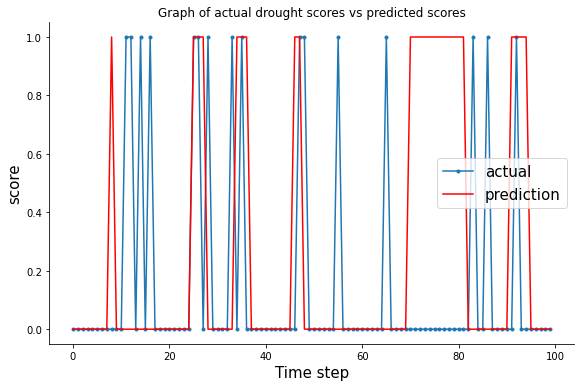

In [122]:
k=[x for x in range(100)]
plt.figure(figsize=(8,5))
plt.plot(k, df_final['score_round'].values[0:100], marker='.', label="actual")
plt.plot(k, df_final['score_pred_round'].values[0:100], 'r', label="prediction")
plt.tight_layout()
plt.title("Graph of actual drought scores vs predicted scores")
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('score', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

###### Accuracy, Precision, Recall, AUC values for predictions computed using LSTM model


In [123]:
print("accuracy",metrics.accuracy_score(df_final['score_round'], df_final['score_pred_round']))
print("f1 score",metrics.f1_score(df_final['score_round'], df_final['score_pred_round'], average='weighted'))
print("precision score",metrics.precision_score(df_final['score_round'], df_final['score_pred_round'], average='weighted'))
print("recall score",metrics.recall_score(df_final['score_round'], df_final['score_pred_round'], average='weighted'))
print("AUC&ROC",metrics.roc_auc_score(df_final['score_round'], df_final['score_pred_round']))
MAE = metrics.mean_absolute_error(df_final['score_round'], df_final['score_pred_round'])
MSE = mean_squared_error(df_final['score_round'], df_final['score_pred_round'])
RMSE = math.sqrt(MSE)
print("MAE ",MAE)
print("RMSE ",RMSE)


accuracy 0.6322511843984236
f1 score 0.6335786859549086
precision score 0.6349330596059473
recall score 0.6322511843984236
AUC&ROC 0.5009367352214011
MAE  0.36774881560157635
RMSE  0.6064229675742636
